# Introduction

### Configuration

In [1]:
# The cache directories:
cache_path       = '~/data/crcns2021'
image_cache_path = f'{cache_path}/annot-images'
v123_cache_path  = f'{cache_path}/annot-v123'
csulc_cache_path = f'{cache_path}/annot-csulc'
trace_save_path = f'~/projects/hcp-annot-vc/save' # modified
labels_path = f'{cache_path}/results/labels'

#If you aren't using /data
import os
os.environ['HCPANNOT_LOAD_PATH'] = cache_path

### Dependencies

In [2]:
import os, sys, pimms, pandas, warnings, urllib, datetime
import numpy as np
import scipy as sp
import scipy.sparse as sps
import nibabel as nib
import neuropythy as ny

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv
import torch, json

In [3]:
%matplotlib inline

In [4]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

### Import `hcpannot`

In [5]:
# Make sure we are in the right directory for this!

if os.getcwd().endswith('/work'):
    #sys.path.append(os.path.abspath('..'))
    sys.path.append(os.path.expanduser('~/projects/hcp-annot-vc'))

# Now we can import the hcp-annot-vc library.
import hcpannot

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = cache_path
# We have to update some data after setting this.

# We also want to grab a few variables from hcpannot:
from hcpannot.interface import default_imshape as roi_image_shape
roi_image_shape = roi_image_shape[0] // 2
from hcpannot.interface import imgrid_to_flatmap
from hcpannot.interface import flatmap_to_imgrid
# The analysis plan (for processing contours):
from hcpannot import vc_plan
# The functions for loading and saving contours.
from hcpannot import (save_contours, load_contours)

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.
from hcpannot import (subject_ids, subject_list_1,
                      subject_list_2, subject_list_3)
sids = np.array(hcpannot.subject_ids)

# We also want to import the IO functions.
from hcpannot.io import (save_traces, export_traces, load_traces, export_paths,
                         load_paths, export_means, calc_surface_areas)
                         #export_labels)

# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import meanrater #plot_vc_contours)

# Finally, we have some multiprocessing tools.
# from hcpannot.mp import (tupcall, okaystr, failstr, retry_sleep, mprun, mpstep,
#                          makejobs)

### Usage Notes

Here's an example code-block using the `plot_vc_contours` function to plot a set of boundaries along with the V1-V3 contours.

```python
dat = vc_plan(rater='BrendaQiu',
              sid=111312,
              hemisphere='lh',
              save_path=trace_save_path)
# Make the flatmap plot and the boundaries.
fig = plot_contours(dat, boundaries=True)
# Extract the pyplot axes that were used.
ax = fig.axes[0]
# Grab the subject data, which includes the V1-V3 contours.
sdat = hcpannot.interface.subject_data[(dat['sid'],dat['hemisphere'])]
# And plot all of these contours:
for (x,y) in sdat['v123'].values():
    ax.plot(x, y, 'w-', lw=0.25)
```

## Work

### Average across raters

In [6]:
raters = ['BrendaQiu', 'JiyeongHa', 'bogengsong', 'lindazelinzhao', 'nourahboujaber', 'jennifertepan']

In [26]:
def plot_contours (raters, subject_id, hemi, roi, path=trace_save_path, plot_average = True):
    
    vcplans = {}
    coordinates = {}
    for r in raters:
        cache_file = os.path.join(path, f"cacherater_{r}_{subject_id}_{hemi}_{roi}.mgz")
        if os.path.isfile(cache_file):
            coordinates[r] = ny.load(cache_file)
        else:
            dat = vc_plan(rater = r, sid = subject_id, hemisphere = hemi, save_path = path)
            vcplans[r] = dat
            try:
                trace = dat['traces'][roi]
                coordinates[r] = trace.curve.linspace(500)
                ny.save(cache_file, coordinates[r])
            except:
                print('missing contour')
            
    # Now we just average the coordinate sets.
    colors = ['r', 'b', 'cyan', 'orange', 'green', 'purple']
    
    if plot_average == True:
        coords_avg = sum(coordinates.values())/len(coordinates)
        coordinates['ave'] = coords_avg
        colors = colors[:(len(coordinates)-1)]+['k']
    else:
        colors = colors[:(len(coordinates))]

    for (c, (x,y)) in zip(colors, coordinates.values()):
        plt.plot(x, y, color = c)
    plt.show()

missing contour
missing contour
missing contour


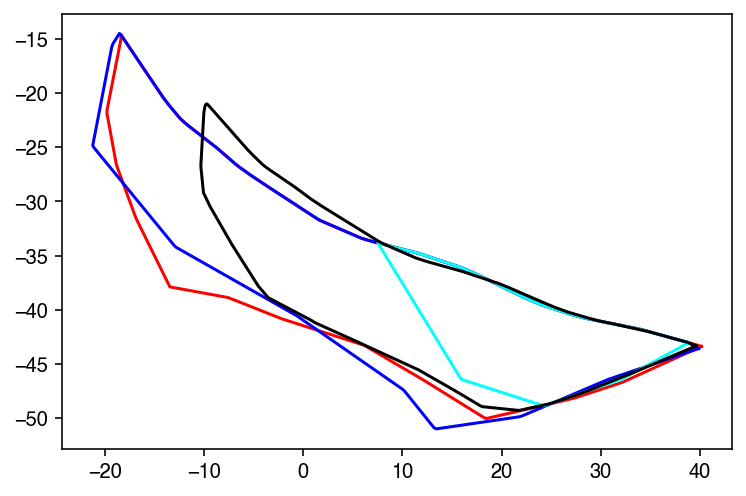

In [27]:
plot_contours(raters, 100610, 'lh', 'hV4', plot_average = True)

In [23]:
!ls {trace_save_path}

Annie-lsc
Asia-Burton
BrendaQiu
BrendaQiu_111312_rh_hV4.mgz
JiyeongHa
README.md
bogengsong
bogengsong_111312_rh_hV4.mgz
cacherater_BrendaQiu_100610_rh_VO1.mgz
cacherater_BrendaQiu_100610_rh_hV4.mgz
cacherater_BrendaQiu_111312_lh_VO1.mgz
cacherater_BrendaQiu_111312_lh_VO2.mgz
cacherater_BrendaQiu_111312_rh_VO1.mgz
cacherater_BrendaQiu_111312_rh_VO2.mgz
cacherater_BrendaQiu_111312_rh_hV4.mgz
cacherater_bogengsong_100610_lh_hV4.mgz
cacherater_bogengsong_100610_rh_VO1.mgz
cacherater_bogengsong_100610_rh_hV4.mgz
cacherater_bogengsong_111312_lh_VO1.mgz
cacherater_bogengsong_111312_lh_VO2.mgz
cacherater_bogengsong_111312_rh_VO1.mgz
cacherater_bogengsong_111312_rh_VO2.mgz
cacherater_bogengsong_111312_rh_hV4.mgz
cacherater_jennifertepan_100610_rh_VO1.mgz
cacherater_jennifertepan_100610_rh_hV4.mgz
cacherater_jennifertepan_111312_lh_VO1.mgz
cacherater_jennifertepan_111312_lh_VO2.mgz
cacherater_jennifertepan_111312_rh_VO1.mgz
cacherater_jennifertepan_111312_rh_VO2.mgz
cacherater_jennifertepan_1113

In [ ]:
# First: Average across two subjects for the same rater.

# Get the traces for one rater and one subject.
dat1 = vc_plan(
    rater=rater1,
    sid=sid1,
    hemisphere='lh',
    save_path=trace_save_path)
dat2 = vc_plan(
    rater=rater1,
    sid=sid2,
    hemisphere='lh',
    save_path=trace_save_path)

In [ ]:
# To average across subjects for a single rater, we need to warp everything
# into the fsaverage so that subject surfaces are aligned.
# To do this we need to make path objects from the trace objects.

# Grab a trace:
trace1 = dat1['traces']['hV4']
# Get the subject's hemisphere data:
hem1 = ny.data['hcp_lines'].subjects[sid1].hemis['lh']

# Turning the trace into a path (which knows about how the trace intersects
# the triangles in the mesh, so we can warp the trace/path into fsaverage
# alignment).
path1 = trace1.to_path(hem1)
# Make an fsaverage-aligned flatmap:
fmap1 = ny.to_flatmap('occipital_pole', hem1)
# Extract x and y coordinates in fsaverage-aligned flatmap.
fsa_coords1 = fmap1.unaddress(path1.addresses)

# Do the same thing for the other trace:
trace2 = dat2['traces']['hV4']
# Get the subject's hemisphere data:
hem2 = ny.data['hcp_lines'].subjects[sid2].hemis['lh']

# Turning the trace into a path (which knows about how the trace intersects
# the triangles in the mesh, so we can warp the trace/path into fsaverage
# alignment).
path2 = trace2.to_path(hem2)
# Make an fsaverage-aligned flatmap:
fmap2 = ny.to_flatmap('occipital_pole', hem2)
# Extract x and y coordinates in fsaverage-aligned flatmap.
fsa_coords2 = fmap2.unaddress(path2.addresses)

In [ ]:
# Plot the two subjects' traces together:
(x, y) = fsa_coords1
plt.plot(x, y, 'k.-')
(x, y) = fsa_coords2
plt.plot(x, y, 'r.-')

In [ ]:
# Average the traces of the subjects together:
curve1 = ny.util.CurveSpline(fsa_coords1)
fsa_normalized_coords1 = curve1.linspace(800)
curve2 = ny.util.CurveSpline(fsa_coords2)
fsa_normalized_coords2 = curve2.linspace(800)

fsa_coords_avg = 0.5 * (fsa_normalized_coords1 + fsa_normalized_coords2)

In [ ]:
(x, y) = fsa_coords1
plt.plot(x, y, 'b.-')
(x, y) = fsa_coords2
plt.plot(x, y, 'r.-')
# Add in the average coordinate.
(x, y) = fsa_coords_avg
plt.plot(x, y, 'k.-')

In [ ]:
# Once you've calculated a set of fsaverage-aligned points, you can save it to
# disk and reload it.
ny.save(f'{sid1}_{rater1}_fsacoords.mgz', fsa_normalized_coords1)

In [ ]:
ny.load(f'{sid1}_{rater1}_fsacoords.mgz')

In [ ]:
# Extract traces for hV4 boundary and split them into 500 evenly-spaced
# points along the boundary.
trace1 = dat1['traces']['hV4'] #'hV4' here can be replaced with 'VO1' or 'VO2'
coords1 = trace1.curve.linspace(500)
trace2 = dat2['traces']['hV4']
coords2 = trace2.curve.linspace(500)

# Now we just average the two coordinate sets.
coords_avg = 0.5 * (coords1 + coords2)

# Plot the average (along with the originals in blue and red).
for (color, (x,y)) in zip(['r', 'b', 'k'], [coords1, coords2, coords_avg]):
    plt.plot(x, y, color + '-')